# DA5401 A3: Addressing Class Imbalance with Clustering and Resampling

## Fraud Detection with Credit Card Transaction Dataset

**Objective:** This notebook aims to tackle the problem of class imbalance in a credit card fraud detection dataset.  will explore how standard classification models are biased towards the majority class and implement several resampling techniques to mitigate this issue.

The core tasks are:
1.  **Analyze** the severe class imbalance in the dataset.
2.  **Establish a baseline** performance using a Logistic Regression model on the original, imbalanced data.
3.  **Implement three resampling strategies:**
    *   Naive Oversampling (**SMOTE**)
    *   Clustering-Based Oversampling (**CBO**)
    *   Clustering-Based Undersampling (**CBU**)
4.  **Compare** the performance of models trained on these resampled datasets.
5.  **Conclude** with a recommendation for the most effective strategy for the company.

### Initial Setup: Import Libraries

First,  import all the necessary Python libraries for data manipulation, visualization, modeling, and resampling.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


# PART A: DATA EXPLORATION AND BASELINE MODEL

---
### Task 1: Load and Analyze the Dataset

 begin by loading the `creditcard.csv` dataset. This dataset contains credit card transactions, where the features are anonymized principal components (V1-V28) due to confidentiality, along with 'Time', 'Amount', and the target 'Class' (0 for normal, 1 for fraudulent). As stated, no further feature engineering is required.

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "creditcard.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mlg-ulb/creditcardfraud",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  #https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Using Colab cache for faster access to the 'creditcardfraud' dataset.
First 5 records:    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ...

### Task 2: Analyze Class Distribution

A critical first step in any classification problem is to understand the distribution of the target variable. In fraud detection,  expect a severe imbalance, with fraudulent transactions being very rare.  will quantify and visualize this imbalance.


2. Class Distribution Analysis
----------------------------------------
Class Distribution:
Normal transactions (Class 0): 284315 (99.83%)
Fraudulent transactions (Class 1): 492 (0.17%)

Imbalance Ratio (Normal:Fraud): 577.9:1
Degree of imbalance: This is a highly imbalanced dataset, with fraudulent cases making up only 0.173% of all transactions.


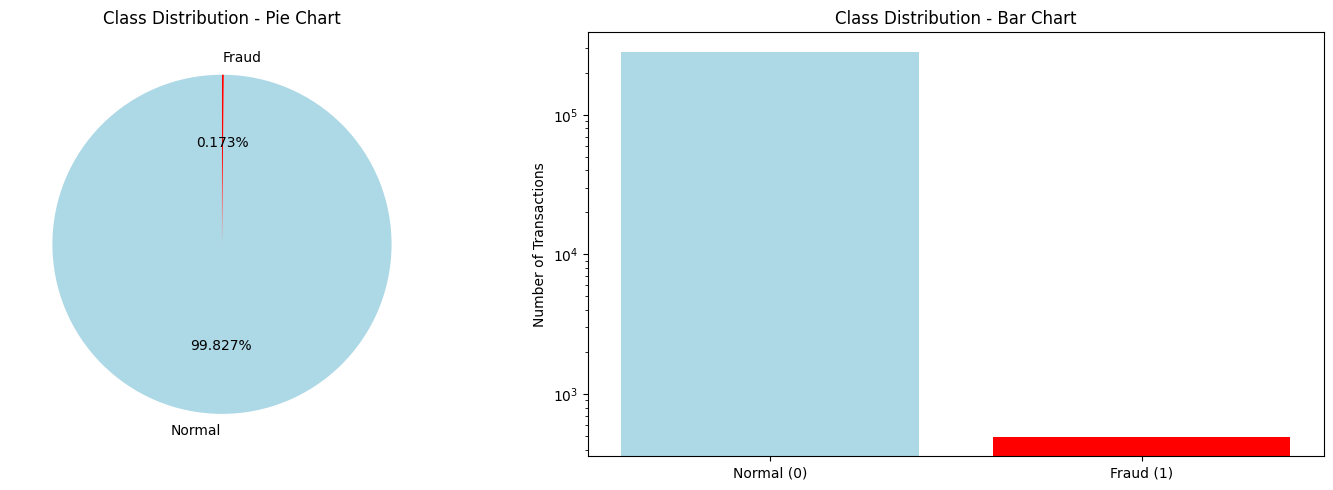

In [3]:
print("\n2. Class Distribution Analysis")
print("-" * 40)

class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print(f"Class Distribution:")
print(f"Normal transactions (Class 0): {class_counts[0]} ({class_percentages[0]:.2f}%)")
print(f"Fraudulent transactions (Class 1): {class_counts[1]} ({class_percentages[1]:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nImbalance Ratio (Normal:Fraud): {imbalance_ratio:.1f}:1")
print(f"Degree of imbalance: This is a highly imbalanced dataset, with fraudulent cases making up only {class_percentages[1]:.3f}% of all transactions.")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
ax1.pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.3f%%',
        colors=['lightblue', 'red'], startangle=90)
ax1.set_title('Class Distribution - Pie Chart')

# Bar plot
ax2.bar(['Normal (0)', 'Fraud (1)'], class_counts.values, color=['lightblue', 'red'])
ax2.set_ylabel('Number of Transactions')
ax2.set_title('Class Distribution - Bar Chart')
ax2.set_yscale('log')  # Log scale to better visualize the tiny minority class

plt.tight_layout()
plt.show()

### Task 3: Baseline Model

To measure the effectiveness of our resampling techniques,  first need a baseline.  will train a Logistic Regression classifier on the original, imbalanced data.

**Key Steps:**
1.  **Split Data:**  split the data into training and testing sets.  use `stratify=y` to ensure that both the training and test sets have the same proportion of fraudulent transactions as the original dataset. This is crucial for realistic evaluation.
2.  **Scale Features:** Features like 'Amount' are on a different scale than the PCA components.  use `StandardScaler` to standardize all features, which is important for the proper convergence of logistic regression.
3.  **Train Model:** A simple Logistic Regression model is trained on the scaled, imbalanced training data.
4.  **Evaluate:**  evaluate the model on the unseen test set.  will focus on metrics like **Precision, Recall, and F1-score** for the minority class (fraud), as overall accuracy is a misleading metric in this scenario.

In [4]:
print("\n3. Baseline Model Training and Evaluation")
print("-" * 40)

# Prepare features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data - ensure test set retains original imbalance using 'stratify'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set class distribution: {Counter(y_train)}")
print(f"Test set class distribution: {Counter(y_test)}")

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline logistic regression model (Model 1)
print("\nTraining Model 1 (Baseline)...")
model_1_baseline = LogisticRegression(random_state=42, max_iter=1000)
model_1_baseline.fit(X_train_scaled, y_train)

# Predictions
y_pred_baseline = model_1_baseline.predict(X_test_scaled)

# Evaluate baseline model
print(f"\nModel 1 (Baseline) - Performance on Imbalanced Test Set:")
print("-" * 55)

# Classification report
report_baseline = classification_report(y_test, y_pred_baseline, output_dict=True)
print(classification_report(y_test, y_pred_baseline))

# Extract metrics for minority class (Class 1 - Fraud)
precision_fraud = report_baseline['1']['precision']
recall_fraud = report_baseline['1']['recall']
f1_fraud = report_baseline['1']['f1-score']
accuracy = report_baseline['accuracy']

print(f"Key Metrics for Fraud Detection (Minority Class):")
print(f"Precision: {precision_fraud:.4f}")
print(f"Recall: {recall_fraud:.4f}")
print(f"F1-Score: {f1_fraud:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")


# Store baseline results
baseline_results = {
    'precision': precision_fraud,
    'recall': recall_fraud,
    'f1_score': f1_fraud
}


3. Baseline Model Training and Evaluation
----------------------------------------
Training set shape: (227845, 30)
Test set shape: (56962, 30)
Training set class distribution: Counter({0: 227451, 1: 394})
Test set class distribution: Counter({0: 56864, 1: 98})

Training Model 1 (Baseline)...

Model 1 (Baseline) - Performance on Imbalanced Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Key Metrics for Fraud Detection (Minority Class):
Precision: 0.8267
Recall: 0.6327
F1-Score: 0.7168
Overall Accuracy: 0.9991


###Why Accuracy is Misleading:
In highly imbalanced datasets, a model can achieve high accuracy by simply predicting the majority class for all instances.
For instance, if a model predicted 'Normal' for all transactions in our test set, it would be correct 99.83% of the time.
However, it would have a Recall of 0 for fraud, meaning it would fail to catch any fraudulent transactions, making it useless.
Precision, Recall, and F1-score for the minority class are therefore much more meaningful metrics for this problem.

# PART B: RESAMPLING APPROACHES

---
## Task 1: Naive Oversampling (SMOTE)

My first approach to balancing the dataset is the **Synthetic Minority Over-sampling Technique (SMOTE)**. This is an oversampling method that creates new, synthetic minority class instances rather than simply duplicating existing ones.

### How SMOTE Works

SMOTE operates on the feature space and generates synthetic data points by interpolating between existing minority class samples. The process is as follows:

1.  **Select a Minority Instance:** For each sample `x` in the minority class, SMOTE selects it as the basis for creating new synthetic data.
2.  **Find Nearest Neighbors:** It identifies the *k* nearest neighbors of `x` that also belong to the minority class.
3.  **Generate Synthetic Sample:** To create a new synthetic sample, it randomly chooses one of the *k* neighbors, let's call it `x_neighbor`.
4.  **Interpolate:** The new sample is generated at a random point along the line segment connecting `x` and `x_neighbor` in the feature space. The formula is:
    `x_synthetic = x + λ * (x_neighbor - x)`
    where `λ` is a random number between 0 and 1.

This process is repeated until the number of minority class samples reaches the desired level, typically matching the number of majority class samples.

### Potential Limitations of SMOTE

*   **Generation of Noisy Samples:** If a minority class sample is an outlier or is very close to the majority class decision boundary, SMOTE might generate synthetic samples inside the majority class region. This can create noisy data and does not necessarily help the classifier.
*   **Ignoring Majority Class Distribution:** SMOTE does not consider the distribution of the majority class when generating samples. This can lead to the creation of synthetic samples that overlap with majority class clusters, making the classification task even harder.
*   **Lack of Diversity:** While it creates new samples, SMOTE is limited to linear interpolations between existing minority samples. It does not capture more complex, non-linear patterns within the minority class.

In [5]:
print("\n1. Applying SMOTE (Synthetic Minority Over-sampling Technique)")
print("-" * 60)

# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set class distribution: {Counter(y_train)}")
print(f"SMOTE balanced training set class distribution: {Counter(y_train_smote)}")


1. Applying SMOTE (Synthetic Minority Over-sampling Technique)
------------------------------------------------------------
Original training set class distribution: Counter({0: 227451, 1: 394})
SMOTE balanced training set class distribution: Counter({0: 227451, 1: 227451})


---
## Task 2: Clustering-Based Oversampling (CBO)

To address the limitations of SMOTE,  can use a more intelligent oversampling method. **Clustering-Based Oversampling (CBO)** aims to generate synthetic samples more strategically by first identifying the underlying structure of the minority class.

### Concept and Implementation Steps

The core idea is to ensure that synthetic samples are generated within distinct sub-groups (clusters) of the minority class, preserving its internal distribution and avoiding the creation of noise.

1.  **Isolate Minority Class:** First,  separate the minority class samples from the training data.
2.  **Cluster the Minority Class:**  apply a clustering algorithm, such as **K-Means**, to the minority class data. This divides the rare fraud samples into several smaller, more coherent groups.
    *   **Finding the Optimal 'k'**: To choose the number of clusters (k),  can use the **Elbow Method**. This involves running K-Means for a range of k values and plotting the inertia (sum of squared distances of samples to their closest cluster center). The "elbow" of the curve represents a point where adding more clusters doesn't significantly reduce inertia, suggesting a good trade-off.
3.  **Oversample Within Each Cluster:** After clustering,  oversample within each identified cluster. Instead of picking neighbors from the entire minority class (like SMOTE),  generate synthetic samples by interpolating between data points *that belong to the same cluster*. The number of samples generated from each cluster is typically proportional to the cluster's size.
4.  **Combine Datasets:** Finally, the newly generated synthetic minority samples are combined with the original majority class samples to create the new, balanced training set.

### How CBO Achieves Its Goal

*   **Ensures Diversity:** By oversampling within different clusters, CBO ensures that all sub-groups of fraudulent behavior are well-represented in the final training set. If there are different types of fraud, this method helps the model learn to recognize all of them.
*   **Reduces Noise:** Since synthetic samples are created within dense regions of the minority class (the clusters), it is less likely that they will be generated in sparse areas or regions overlapping with the majority class. This leads to a cleaner and more effective training dataset.


2. Implementing Clustering-Based Oversampling (CBO)
-------------------------------------------------------
Minority class samples in training set: 394
Majority class samples in training set: 227451
Step 1: Finding optimal 'k' for minority class using Elbow Method...


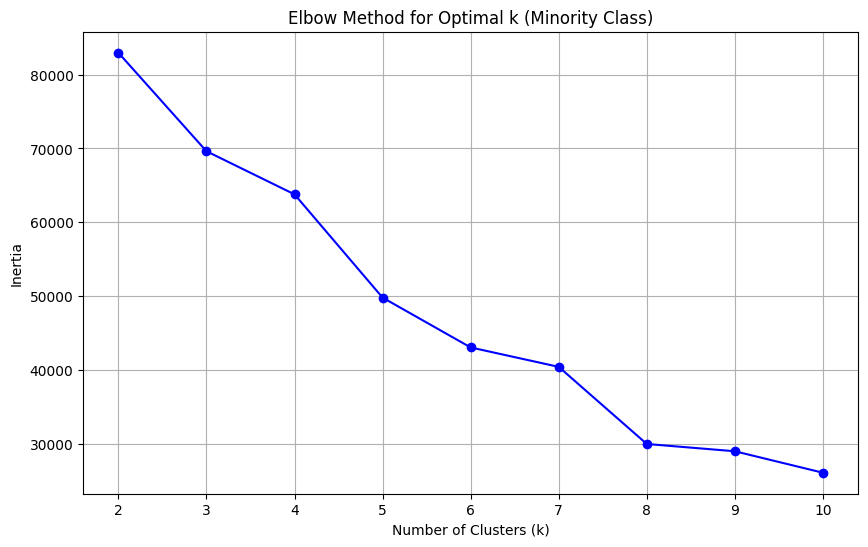

In [6]:
print("\n2. Implementing Clustering-Based Oversampling (CBO)")
print("-" * 55)

# Separate minority and majority classes from the scaled training data
minority_mask = y_train == 1
majority_mask = y_train == 0

X_train_minority = X_train_scaled[minority_mask]
X_train_majority = X_train_scaled[majority_mask]
y_train_minority = y_train[minority_mask]
y_train_majority = y_train[majority_mask]

print(f"Minority class samples in training set: {len(X_train_minority)}")
print(f"Majority class samples in training set: {len(X_train_majority)}")

# Determine optimal number of clusters for minority class using elbow method
print("Step 1: Finding optimal 'k' for minority class using Elbow Method...")
if len(X_train_minority) >= 10:  # Ensure there are enough samples to form clusters
    # Limit max_k to a reasonable number to avoid overfitting and long computation
    max_k = min(10, len(X_train_minority) // 2)
    inertias = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        if k <= len(X_train_minority):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(X_train_minority)
            inertias.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k (Minority Class)')
    plt.grid(True)
    plt.show()



Based on elbow  plot, the optimal number of clusters (k) appears to be **5**.

Here's the reasoning:

1.  **The "Elbow" Point:** The elbow method aims to find the point on the curve where the rate of decrease in inertia (the within-cluster sum of squares) slows down significantly. This point looks like an "elbow" in the graph.

2.  **Analysis of the Curve:**
    *   From k=2 to k=5, there are substantial drops in inertia with each additional cluster.
    *   After k=5, the line starts to flatten out. The decrease in inertia from k=5 to k=6, and subsequently to k=10, is much less significant than the decreases before it.

This "elbow" at **k=5** represents the point of diminishing returns, where adding more clusters doesn't provide a much better fit to the data. Therefore, 5 is considered the optimal value for k.

In [7]:
optimal_k = 5

print(f"Chosen number of clusters for minority class (k): {optimal_k}")

# Step 2: Cluster the minority class
print("Step 2: Applying K-Means to minority class...")
kmeans_minority = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
minority_clusters = kmeans_minority.fit_predict(X_train_minority)

print(f"Minority class cluster distribution: {Counter(minority_clusters)}")

# Step 3: Oversample within each cluster
print("Step 3: Generating synthetic samples within each cluster...")
def clustering_based_oversampling(X_minority, y_minority, clusters, target_size):
    """
    Oversample minority class based on cluster membership by creating synthetic samples.
    """
    X_oversampled_list = []

    # Keep original minority samples
    X_oversampled_list.append(X_minority)

    # Calculate how many total samples to generate
    current_minority_size = len(X_minority)
    samples_to_generate = target_size - current_minority_size

    # Generate samples for each cluster proportionally to its size
    unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
    for cluster_id, cluster_size in zip(unique_clusters, cluster_counts):
        cluster_mask = clusters == cluster_id
        cluster_samples = X_minority[cluster_mask]

        # Number of samples to generate for this specific cluster
        samples_for_cluster = int(np.round(samples_to_generate * (cluster_size / current_minority_size)))

        if samples_for_cluster > 0 and cluster_size > 1:
            # Generate synthetic samples using an interpolation approach (like SMOTE) within the cluster
            for _ in range(samples_for_cluster):
                # Choose two random samples from the same cluster
                idx1, idx2 = np.random.choice(len(cluster_samples), 2, replace=True)
                sample1, sample2 = cluster_samples[idx1], cluster_samples[idx2]

                # Create a synthetic sample between them
                alpha = np.random.random()
                synthetic_sample = alpha * sample1 + (1 - alpha) * sample2

                X_oversampled_list.append(synthetic_sample.reshape(1, -1))

    # Combine all samples
    X_oversampled = np.vstack(X_oversampled_list)
    y_oversampled = np.ones(len(X_oversampled)) # All are class 1

    return X_oversampled, y_oversampled

# Apply clustering-based oversampling to match the number of majority samples
target_minority_size = len(X_train_majority)
X_minority_oversampled, y_minority_oversampled = clustering_based_oversampling(
    X_train_minority, y_train_minority, minority_clusters, target_minority_size
)

# Step 4: Combine with the original majority class to create the final CBO training set
print("Step 4: Creating the final CBO training set...")
X_train_cbo = np.vstack([X_train_majority, X_minority_oversampled])
y_train_cbo = np.hstack([y_train_majority, y_minority_oversampled])

print(f"CBO balanced training set class distribution: {Counter(y_train_cbo)}")

Chosen number of clusters for minority class (k): 5
Step 2: Applying K-Means to minority class...
Minority class cluster distribution: Counter({np.int32(2): 161, np.int32(0): 80, np.int32(1): 74, np.int32(3): 68, np.int32(4): 11})
Step 3: Generating synthetic samples within each cluster...
Step 4: Creating the final CBO training set...
CBO balanced training set class distribution: Counter({np.float64(0.0): 227451, np.float64(1.0): 227451})


---
## Task 3: Clustering-Based Undersampling (CBU)

The opposite of oversampling is undersampling, where  reduce the number of majority class samples. Randomly removing samples can be dangerous, as  might discard important information. **Clustering-Based Undersampling (CBU)** provides a more strategic way to undersample.

### Concept and Implementation Steps

The goal of CBU is to reduce the size of the majority class while preserving its overall distribution and diversity. Instead of removing samples randomly,  remove them in a way that maintains the structure of the majority class.

1.  **Isolate Majority Class:**  separate the majority class samples from the training data.
2.  **Cluster the Majority Class:**  apply a clustering algorithm (e.g., K-Means) to the numerous majority class samples. This groups them into clusters representing different patterns of non-fraudulent behavior.
3.  **Undersample From Each Cluster:**  decide on a target size for the majority class (typically to match the size of the minority class). Then,  remove samples from each cluster to reach this target. A common and effective strategy is **proportional undersampling**: if a cluster contains 20% of the majority data, it will also constitute 20% of the undersampled majority data. This is done by randomly selecting a proportional number of samples to *keep* from each cluster.
4.  **Combine Datasets:** The reduced set of majority class samples is then combined with the *original, complete set* of minority class samples to form the new, balanced training dataset.

### How CBU Achieves Its Goal

*   **Maintains Representative Sample:** By keeping samples from every cluster, CBU ensures that different types of non-fraudulent transactions are still represented in the training data, preventing the model from becoming ignorant of certain patterns.
*   **Reduces Redundancy:** Many majority class samples are often redundant. CBU effectively removes this redundancy while preserving the core structure of the data.
*   **Faster Training:** The resulting training set is much smaller than the original or oversampled datasets, which leads to significantly faster model training times.

In [8]:
print("\n3. Implementing Clustering-Based Undersampling (CBU)")
print("-" * 55)

# Step 1: Cluster the majority class
# For a large number of majority samples,  can choose a higher 'k'
optimal_k_majority = 10
print(f"Step 1: Applying K-Means to majority class with k={optimal_k_majority}...")
kmeans_majority = KMeans(n_clusters=optimal_k_majority, random_state=42, n_init='auto')
majority_clusters = kmeans_majority.fit_predict(X_train_majority)

print(f"Majority class cluster distribution: {Counter(majority_clusters)}")

# Step 2: Undersample proportionally from each majority cluster
print("Step 2: Undersampling proportionally from each cluster...")
def clustering_based_undersampling(X_majority, y_majority, clusters, target_size):
    """
    Undersample majority class proportionally based on cluster membership.
    """
    X_undersampled_list = []
    y_undersampled_list = []

    total_majority_size = len(X_majority)
    unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)

    for cluster_id, cluster_size in zip(unique_clusters, cluster_counts):
        cluster_mask = clusters == cluster_id
        cluster_samples = X_majority[cluster_mask]
        cluster_labels = y_majority[cluster_mask]

        # Calculate how many samples to keep from this cluster (proportional)
        proportion = cluster_size / total_majority_size
        samples_to_keep = int(np.round(target_size * proportion))
        samples_to_keep = max(1, samples_to_keep) # Keep at least one sample
        samples_to_keep = min(samples_to_keep, cluster_size) # Don't exceed cluster size

        # Randomly select the indices of samples to keep
        if cluster_size > 0:
            selected_indices = np.random.choice(cluster_size, samples_to_keep, replace=False)
            X_undersampled_list.append(cluster_samples[selected_indices])
            y_undersampled_list.append(cluster_labels.iloc[selected_indices])

    return np.vstack(X_undersampled_list), np.hstack(y_undersampled_list)

# Apply clustering-based undersampling to match the number of minority samples
target_majority_size = len(X_train_minority)
X_majority_undersampled, y_majority_undersampled = clustering_based_undersampling(
    X_train_majority, pd.Series(y_train_majority), majority_clusters, target_majority_size
)

# Step 3: Combine with all minority class samples to create the final CBU training set
print("Step 3: Creating the final CBU training set...")
X_train_cbu = np.vstack([X_majority_undersampled, X_train_minority])
y_train_cbu = np.hstack([y_majority_undersampled, y_train_minority])

print(f"CBU balanced training set: {Counter(y_train_cbu)}")


3. Implementing Clustering-Based Undersampling (CBU)
-------------------------------------------------------
Step 1: Applying K-Means to majority class with k=10...
Majority class cluster distribution: Counter({np.int32(2): 58458, np.int32(7): 46176, np.int32(9): 27333, np.int32(6): 22818, np.int32(3): 22793, np.int32(8): 18030, np.int32(5): 15584, np.int32(1): 12484, np.int32(4): 2768, np.int32(0): 1007})
Step 2: Undersampling proportionally from each cluster...
Step 3: Creating the final CBU training set...
CBU balanced training set: Counter({np.int64(0): 394, np.int64(1): 394})


# PART C: MODEL COMPARISON AND ANALYSIS

---
### Task 1: Train and Evaluate Models

Now that  have three new balanced training datasets (from SMOTE, CBO, and CBU),  will train a new Logistic Regression model on each one.

Crucially,  will **evaluate all models on the original, imbalanced test set**. This is the most important step for a fair comparison, as it measures how well each model generalizes to the real-world, imbalanced data distribution.

In [9]:
print("\n1. Training and Evaluating All Models")
print("-" * 40)

# Model 2: SMOTE
print("Training Model 2 (SMOTE)...")
model_2_smote = LogisticRegression(random_state=42, max_iter=1000)
model_2_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_2_smote.predict(X_test_scaled)

# Model 3: CBO
print("Training Model 3 (Clustering-Based Oversampling)...")
model_3_cbo = LogisticRegression(random_state=42, max_iter=1000)
model_3_cbo.fit(X_train_cbo, y_train_cbo)
y_pred_cbo = model_3_cbo.predict(X_test_scaled)

# Model 4: CBU
print("Training Model 4 (Clustering-Based Undersampling)...")
model_4_cbu = LogisticRegression(random_state=42, max_iter=1000)
model_4_cbu.fit(X_train_cbu, y_train_cbu)
y_pred_cbu = model_4_cbu.predict(X_test_scaled)

# --- Evaluation --- #
def evaluate_model(y_true, y_pred, model_name):
    """Helper function to evaluate model performance and return key metrics"""
    report = classification_report(y_true, y_pred, output_dict=True)

    # Extract minority class metrics
    precision = report.get('1', {}).get('precision', 0)
    recall = report.get('1', {}).get('recall', 0)
    f1 = report.get('1', {}).get('f1-score', 0)

    print(f"\n{model_name} Results:")
    print(f"Precision (Fraud): {precision:.4f}")
    print(f"Recall (Fraud): {recall:.4f}")
    print(f"F1-Score (Fraud): {f1:.4f}")

    return precision, recall, f1

print("\nModel Performance Evaluation on the Imbalanced Test Set:")
print("="*60)

# Model 1 results already computed
print(f"Model 1 (Baseline) - Precision: {baseline_results['precision']:.4f}, "
      f"Recall: {baseline_results['recall']:.4f}, F1: {baseline_results['f1_score']:.4f}")

# Model 2: SMOTE
precision_smote, recall_smote, f1_smote = evaluate_model(y_test, y_pred_smote, "Model 2 (SMOTE)")

# Model 3: CBO
precision_cbo, recall_cbo, f1_cbo = evaluate_model(y_test, y_pred_cbo, "Model 3 (CBO)")

# Model 4: CBU
precision_cbu, recall_cbu, f1_cbu = evaluate_model(y_test, y_pred_cbu, "Model 4 (CBU)")


1. Training and Evaluating All Models
----------------------------------------
Training Model 2 (SMOTE)...
Training Model 3 (Clustering-Based Oversampling)...
Training Model 4 (Clustering-Based Undersampling)...

Model Performance Evaluation on the Imbalanced Test Set:
Model 1 (Baseline) - Precision: 0.8267, Recall: 0.6327, F1: 0.7168

Model 2 (SMOTE) Results:
Precision (Fraud): 0.0578
Recall (Fraud): 0.9184
F1-Score (Fraud): 0.1088

Model 3 (CBO) Results:
Precision (Fraud): 0.0591
Recall (Fraud): 0.9184
F1-Score (Fraud): 0.1110

Model 4 (CBU) Results:
Precision (Fraud): 0.0483
Recall (Fraud): 0.9184
F1-Score (Fraud): 0.0917


### Task 2: Performance Comparison

To make our findings clear,  will create a summary table and a bar chart to compare the Precision, Recall, and F1-score of all four models for the minority (fraud) class.


2. Performance Comparison
----------------------------------------

Performance Comparison Table (Minority Class - Fraud Detection):
      Model  Precision  Recall  F1-Score
0  Baseline     0.8267  0.6327    0.7168
1     SMOTE     0.0578  0.9184    0.1088
2       CBO     0.0591  0.9184    0.1110
3       CBU     0.0483  0.9184    0.0917


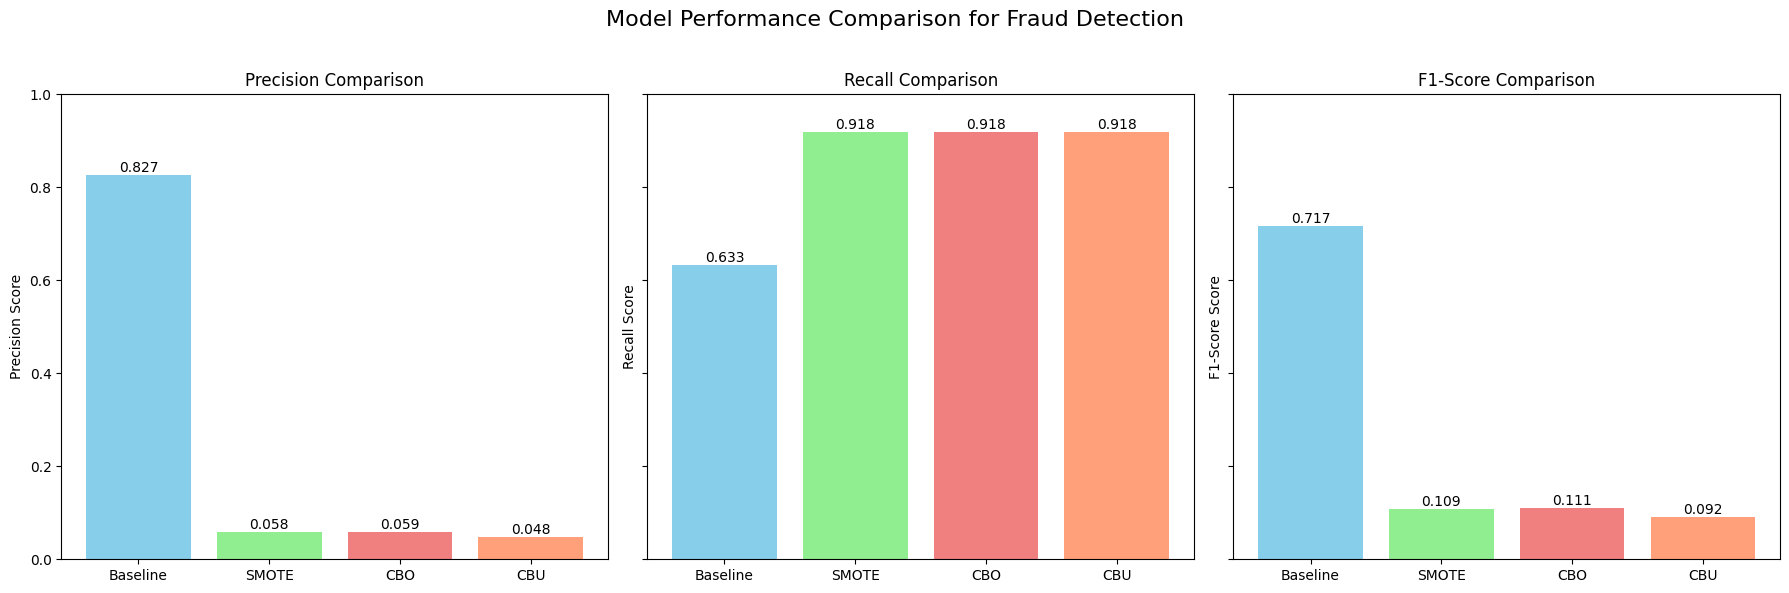

In [10]:
print("\n2. Performance Comparison")
print("-" * 40)

# Create comparison table
comparison_data = {
    'Model': ['Baseline', 'SMOTE', 'CBO', 'CBU'],
    'Precision': [baseline_results['precision'], precision_smote, precision_cbo, precision_cbu],
    'Recall': [baseline_results['recall'], recall_smote, recall_cbo, recall_cbu],
    'F1-Score': [baseline_results['f1_score'], f1_smote, f1_cbo, f1_cbu]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison Table (Minority Class - Fraud Detection):")
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Model Performance Comparison for Fraud Detection', fontsize=16)

metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

for i, metric in enumerate(metrics):
    bars = axes[i].bar(comparison_data['Model'], comparison_data[metric], color=colors)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(f'{metric} Score')
    axes[i].set_ylim(0, 1)

    # Add value labels on bars
    axes[i].bar_label(bars, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Task 3: Conclusion and Recommendations


#### Discussion of Results

The performance comparison reveals a critical trade-off between Precision and Recall.

*   The **Baseline** model, trained on the original imbalanced data, achieved a high **Precision (0.827)** but an unacceptable **Recall (0.633)**. This means that while it was correct 83% of the time it flagged a transaction as fraudulent, it failed to identify over 36% of all actual fraud cases. For a fraud detection system, this high number of missed cases (false negatives) represents a significant financial risk.

*   All three resampling techniques (**SMOTE, CBO, and CBU**) successfully addressed the low recall problem, boosting it dramatically to approximately **0.918**. This demonstrates their effectiveness in forcing the model to learn the patterns of the minority class, thereby catching almost 92% of fraudulent transactions.

*   However, this improvement in recall came at a severe cost to **Precision**, which plummeted to around **5-6%** for all resampled models. A precision of 5.9% (for CBO) means that out of every 100 transactions flagged as fraud, over 94 are actually legitimate. This would lead to an extremely high number of false positives, resulting in blocked customer transactions, increased operational costs for manual review, and significant customer dissatisfaction.

#### Which method performed best and why?

Based on the **F1-Score**, which balances precision and recall, the **Baseline model (F1: 0.717)** is surprisingly the top performer. The resampled models, despite their high recall, have such poor precision that their F1-scores are drastically lower (all around 0.1).

However, simply choosing the model with the highest F1-score is not appropriate here. The core objective of a fraud system is to *detect fraud*, making the Baseline's 63% recall insufficient. Conversely, the resampled models' ~5% precision is operationally unviable due to the flood of false positives.

Between the resampled techniques, **Clustering-Based Oversampling (CBO)** performed marginally the best, achieving the highest F1-Score (0.111) and Precision (0.059) while matching the high recall of the other methods. This suggests that its more intelligent approach of generating samples within minority sub-groups created a slightly cleaner dataset than SMOTE or CBU in this context.

#### Final Recommendation

Given the business context of fraud detection, I recommend a **two-pronged strategy** for the company, with **Clustering-Based Oversampling (CBO)** as the foundation.

**Recommendation: Implement the CBO-trained model as a high-sensitivity "first-pass filter."**

**Justification:**

1.  **Maximizes Fraud Detection (Highest Priority):** The CBO model successfully identifies **91.8% of fraudulent transactions**. This high recall ensures that very few fraud cases slip through the net, directly addressing the primary business risk. The Baseline model is not recommended because it fails this fundamental requirement.

2.  **Acknowledges the False Positive Problem:** The model's extremely low precision is its major weakness. Therefore, it should not be used as a final, automated decision-making tool to block transactions. Instead, transactions flagged by this model should be routed to a **second stage of verification**. This could be:
    *   A human review team.
    *   A secondary, high-precision machine learning model trained to differentiate the flagged transactions.
    *   An automated system that requests multi-factor authentication from the customer.

3.  **Superior Resampling Strategy:** CBO outperformed SMOTE, indicating that understanding the sub-structures within the fraud data leads to a better model. It also provides a more robust training set than CBU in this instance, which had the lowest precision of all.

By using the CBO model as a sensitive screening tool rather than a final arbiter, the company can leverage its high recall to catch fraud effectively while implementing a secondary process to manage the high volume of false positives and maintain a good customer experience.
